# Depression and Anxiety base classification

Based on the study by [Cavanagh et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6515849/)

Import packages

In [191]:
import io
import mne
import copy
import glob
import array
import matplotlib
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
import scipy.io as sio
import plotly.express as px
import matplotlib.pyplot as plt


from itertools import chain
from sklearn.svm import SVC
from scipy.io import loadmat
from sklearn import set_config

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import permutation_test_score


import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, RepeatedStratifiedKFold
from sklearn.utils import resample

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer

from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

from scipy import stats

# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

### Load data

In [192]:
# ctrl_dep['BDI'].to_numpy()

## Classification

In [193]:
random_state = 42

In [194]:
# Calculating p-value with permutation test from sci-kit learn

def calculate_p_permutations(estimator, X, y, cv=3, n_permutations=1000, n_jobs=1):

    score_, perm_scores_, pvalue_ = permutation_test_score(
        estimator, X, y, cv=cv, n_permutations=n_permutations, n_jobs=n_jobs
    )

    # summarize
    print(f"     The permutation P-value is = {pvalue_:.4f}")
    print(f"     The permutation score is = {score_:.4f}\n")

    return score_, pvalue_

In [195]:
def evaluate_GS_model(
    pipe,
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    classifier_params,
    pipeline_name,
    cv=StratifiedKFold(n_splits=5),
    predict_test = True,
    predict_train = True,
    ):
    
    # define grid search
    grid_search_model = GridSearchCV(
        pipe,
        classifier_params,
        cv=cv,
        scoring={"roc_auc", "balanced_accuracy", "precision", "recall"},
        refit="balanced_accuracy",
        return_train_score=True,
        verbose=10,
        n_jobs=1,
        
    )

    # fit model
    grid_search_model.fit(X_train, y_train)

    # predict test data
    # y_test_pred = grid_search_model.predict(X_test) if predict_test is True else None
    # test_score = roc_auc_score(y_test, y_test_pred) if predict_test is True else None

    # predict train data
    y_train_pred = grid_search_model.predict(X_train) if predict_train is True else None
    train_score = balanced_accuracy_score(y_train, y_train_pred) if predict_train is True else None 

    # extract mean cv scores
    mean_cv_score = grid_search_model.best_score_
    
    # report
    # classification_report_ = classification_report(y_test, y_test_pred, labels=[0,1])

    # extract splits scores
    # ta linijka wyciąga z cv_results, czyli z DF z wynikami wszystkich testowanych 
    # w GS parametrów scory na kolejnych splitach cross-validacji
    cv_results_df = pd.DataFrame(grid_search_model.cv_results_).iloc[[grid_search_model.best_index_]]
    cv_splits_scores_df = cv_results_df.filter(regex=r"split\d*_test_roc_auc").reset_index(drop=True) 

    # wyciąganie scorów na teście dla matryk zdefiniowanych w scoring
    metrics_results_df = cv_results_df.filter(regex=r"mean_test_*").reset_index(drop=True)
    
    # calculate p-value
    scores_, pvalue_ = calculate_p_permutations(
            grid_search_model.best_estimator_, X_train, y_train, cv=cv
        )


    # save results in dataframe
    this_result = pd.concat(
        [
            pd.DataFrame({
            "model_name": [pipe.steps[-1][0]],
            "pipeline_name": [pipeline_name],
            "train score": [train_score],
            "mean_cv_score": [mean_cv_score],
            # "test_score": [test_score],
            "best_model": [grid_search_model.best_estimator_],
            "parameters": [grid_search_model.best_params_],
            "pvalue":[pvalue_],    
            }),
         cv_splits_scores_df,
         metrics_results_df,
        ],
    axis=1
    ) 

    return this_result

In [196]:
def evaluate_GS_model(
    pipe, 
    X, 
    y, 
    classifier_params, 
    pipeline_name, 
    cv=StratifiedKFold(n_splits=5),
    predict_test=True, 
    predict_train=True):
    
    # define grid search
    grid_search_model = GridSearchCV(
        pipe,
        classifier_params,
        cv=cv,
        scoring={"roc_auc", "balanced_accuracy", "precision", "recall"},
        refit="balanced_accuracy",
        return_train_score=True,
        verbose=10,
        n_jobs=1,
    )

    # fit model
    grid_search_model.fit(X, y)

    # predict test data
    # y_test_pred = grid_search_model.predict(X_test) if predict_test is True else None
    # test_score = roc_auc_score(y_test, y_test_pred) if predict_test is True else None

    # predict train data
    y_train_pred = grid_search_model.predict(X) if predict_train is True else None
    train_score = balanced_accuracy_score(y, y_train_pred) if predict_train is True else None 

    # extract mean cv scores
    mean_cv_score = grid_search_model.best_score_
    
    # report
    # classification_report_ = classification_report(y_test, y_test_pred, labels=[0,1])

    # extract splits scores
    # ta linijka wyciąga z cv_results, czyli z DF z wynikami wszystkich testowanych 
    # w GS parametrów scory na kolejnych splitach cross-validacji
    cv_results_df = pd.DataFrame(grid_search_model.cv_results_).iloc[[grid_search_model.best_index_]]
    cv_splits_scores_df = cv_results_df.filter(regex=r"split\d*_test_roc_auc").reset_index(drop=True) 

    # wyciąganie scorów na teście dla matryk zdefiniowanych w scoring
    metrics_results_df = cv_results_df.filter(regex=r"mean_test_*").reset_index(drop=True)
    
    # calculate p-value
    scores_, pvalue_ = calculate_p_permutations(
            grid_search_model.best_estimator_, X, y, cv=cv
        )


    # save results in dataframe
    this_result = pd.concat(
        [
            pd.DataFrame({
            "model_name": [pipe.steps[-1][0]],
            "pipeline_name": [pipeline_name],
            "train score": [train_score],
            "mean_cv_score": [mean_cv_score],
            # "test_score": [test_score],
            "best_model": [grid_search_model.best_estimator_],
            "parameters": [grid_search_model.best_params_],
            "pvalue":[pvalue_],    
            }),
         cv_splits_scores_df,
         metrics_results_df,
        ],
        axis=1
    ) 

    return this_result

Define estimators

In [197]:
lg = ('lg', LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'))
lg_params = dict()

svc = ('svc' , SVC())
svc_params = dict(
    svc__kernel=["linear", "rbf"],
    svc__C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
)

lda = ("lda", LinearDiscriminantAnalysis())
lda_params = dict(
    lda__solver = ["lsqr", "eigen"],
    lda__shrinkage = ["auto"],
)


estimators = [
    (lg, lg_params),
    (svc, svc_params),
    (lda, lda_params)
]

Define CSP

In [198]:
csp = ('csp', CSP(log=None, norm_trace=False))
csp_params = dict(
    csp__n_components = [1,2,3,4],
    csp__reg = [0.0001, 0.001, 0.01, 0.1, 1, 10]
)

### Data loading

In [199]:
data = pd.read_pickle("data/feedback_export_Kuba/sonata_data_GNG_autoreject_short_epochs.pkl")

In [200]:
dep = [data.iloc[part] for part in range(len(data)) if data['BDI'][part] > 13 and data['STAI'][part] > 41]
dep = pd.DataFrame(dep)
len(dep)

75

In [201]:
ctrl_dep = [data.iloc[part] for part in range(len(data)) if data['BDI'][part] <= 13 and data['STAI'][part] > 41]
ctrl_dep = pd.DataFrame(ctrl_dep)
len(ctrl_dep)

72

In [202]:
anx = [data.iloc[part] for part in range(len(data)) if data['BDI'][part] <= 13 and data['STAI'][part] > 42]
anx = pd.DataFrame(anx)
len(anx)

65

In [203]:
ctrl_anx = [data.iloc[part] for part in range(len(data)) if data['BDI'][part] <= 13 and data['STAI'][part] < 41]
ctrl_anx = pd.DataFrame(ctrl_anx)
len(ctrl_anx)

66

In [204]:
frn_first_max=0.12
tmin = 0.2
tmax = 0.3
picks = ["FCz"]

In [205]:
def get_rewps(epochs, tmin, tmax):
  rewps = []
  for i in range(len(epochs)):
    avg = epochs.iloc[i]['epochs']['f_good'].average().get_data(picks=picks, tmin=tmin, tmax=tmax)
    rewps.append(avg.mean())
  return rewps

In [206]:
dep_data = []
dep_data = get_rewps(dep, tmin, tmax)

In [207]:
ctrl_data = []
ctrl_data = get_rewps(ctrl_dep, tmin, tmax)

### Depression vs Control

#### RewP

In [20]:
X = pd.DataFrame(pd.concat([pd.DataFrame(dep_data), pd.DataFrame(ctrl_data)]))
y = np.array(len(dep_data) * [1] +  len(ctrl_data) * [0])
len(y)

147

In [21]:
%%capture

results_dep_rewp_df = pd.DataFrame()

vec = Vectorizer()
# cv = ShuffleSplit(3, test_size=0.3, random_state=random_state)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=random_state)

for (estimator, params) in estimators:
    print(f"Rating {estimator} \n")
    pipeline_name = "RewP_Depression_" + estimator[0]
    
      # create pipeline from base steps list and estimator
    pipe = Pipeline([estimator])

      # enter to grid search
    grid_result = evaluate_GS_model(
        pipe,
        X,
        y,
        params,
        pipeline_name=pipeline_name,
        cv=cv
    )
    print(grid_result)

    results_dep_rewp_df = pd.concat([results_dep_rewp_df, grid_result])

In [22]:
results_dep_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,RewP_Depression_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000
0,svc,RewP_Depression_svc,0.559444,0.530833,(SVC(C=1)),"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.318681,0.511667,0.603333,0.486667,0.520000,0.533889,0.530833,0.555051
0,lda,RewP_Depression_lda,0.571389,0.550556,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.165834,0.595000,0.666667,0.516667,0.573333,0.592778,0.550556,0.558776


In [23]:
results_dep_rewp_df.to_pickle("data/depression_rewp_results_gng_06_06_23_1.pkl")

#### FRN

In [24]:
def get_fnrs(epochs, tmin, tmax):
  frns = []
  for i in range(len(epochs)):
    diff = epochs.iloc[i]['epochs']['f_bad'].average().get_data(picks=picks, tmin=tmin, tmax=tmax).max() - epochs.iloc[i]['epochs']['f_bad'].average().get_data(picks=picks, tmin=tmin, tmax=tmax).min()
    frns.append(diff)
  return frns

In [25]:
dep_data = []
ctrl_data = []
dep_data = get_fnrs(dep, tmin, tmax)
ctrl_data = get_fnrs(ctrl_dep, tmin, tmax)

In [26]:
X = pd.DataFrame(pd.concat([pd.DataFrame(dep_data), pd.DataFrame(ctrl_data)]))
y = np.array(len(dep_data) * [1] +  len(ctrl_data) * [0])
len(y)

147

In [27]:
%%capture

results_dep_frn_df = pd.DataFrame()

vec = Vectorizer()
# cv = ShuffleSplit(3, test_size=0.3, random_state=random_state)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=random_state)

for (estimator, params) in estimators:
    print(f"Rating {estimator} \n")
    pipeline_name = "FRN_Depression_" + estimator[0]
    
      # create pipeline from base steps list and estimator
    pipe = Pipeline([estimator])

      # enter to grid search
    grid_result = evaluate_GS_model(
        pipe,
        X,
        y,
        params,
        pipeline_name=pipeline_name,
        predict_test = True,
        predict_train = True,
        cv=cv
    )
    print(grid_result)

    results_dep_frn_df = pd.concat([results_dep_frn_df, grid_result])

In [28]:
results_dep_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,FRN_Depression_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.0,0.500000,0.500000,0.000000
0,svc,FRN_Depression_svc,0.500000,0.500000,"(SVC(C=0.0001, kernel='linear'))","{'svc__C': 0.0001, 'svc__kernel': 'linear'}",1.000000,0.399167,0.577500,0.523333,1.0,0.500000,0.500000,0.510204
0,lda,FRN_Depression_lda,0.525278,0.476389,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.734266,0.400000,0.576667,0.515000,0.8,0.497222,0.476389,0.486294


In [29]:
results_dep_frn_df.to_pickle("data/depression_frn_gng_06_06_23_2.pkl")

In [30]:
# # plot CSP patterns estimated on full data for visualization
# epochs_train = dep_epochs[0]['bad'].copy().crop(tmin=tmin, tmax=tmax).pick_types(eeg=True)
# epochs_train.info

# csp.fit_transform(evoked_data, y)

# fig = csp.plot_patterns(epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

In [31]:
# clf.fit(evoked_data, y)

# clf[-1].coef_

### Anxiety vs Control

#### RewP

In [32]:
anx_data = []
ctrl_data = []
anx_data = get_rewps(anx, tmin, tmax)
ctrl_data = get_rewps(ctrl_anx, tmin, tmax)

In [33]:
X = pd.DataFrame(pd.concat([pd.DataFrame(anx_data), pd.DataFrame(ctrl_data)]))
y = np.array(len(anx_data) * [1] +  len(ctrl_data) * [0])
len(y)

131

In [34]:
print(f"ANX len: {len(anx_data)}\nCTR len: {len(ctrl_data)}")

ANX len: 65
CTR len: 66


In [35]:
%%capture

results_anx_rewp_df = pd.DataFrame()

vec = Vectorizer()
# cv = ShuffleSplit(3, test_size=0.3, random_state=random_state)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=random_state)

for (estimator, params) in estimators:
    print(f"Rating {estimator} \n")
    pipeline_name = "RewP_Anxiety_" + estimator[0]
    
      # create pipeline from base steps list and estimator
    pipe = Pipeline([estimator])

      # enter to grid search
    grid_result = evaluate_GS_model(
        pipe,
        X,
        y,
        params,
        pipeline_name=pipeline_name,
        predict_test = True,
        predict_train = True,
        cv=cv
    )
    print(grid_result)

    results_anx_rewp_df = pd.concat([results_anx_rewp_df, grid_result])

In [36]:
results_anx_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,RewP_Anxiety_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000
0,svc,RewP_Anxiety_svc,0.500000,0.485570,"(SVC(C=0.0001, kernel='linear'))","{'svc__C': 0.0001, 'svc__kernel': 'linear'}",0.795205,0.479339,0.415289,0.385281,0.031746,0.426636,0.485570,0.111111
0,lda,RewP_Anxiety_lda,0.501049,0.412338,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.974026,0.479339,0.413223,0.385281,0.324675,0.425948,0.412338,0.386364


In [37]:
results_anx_rewp_df.to_pickle("data/anxiety_rewp_results_gng_06_06_23_3.pkl")

#### FRN

In [38]:
anx_data = []
ctrl_data = []
anx_data = get_fnrs(anx, tmin, tmax)
ctrl_data = get_fnrs(ctrl_anx, tmin, tmax)

In [39]:
X = pd.DataFrame(pd.concat([pd.DataFrame(anx_data), pd.DataFrame(ctrl_data)]))
y = np.array(len(anx_data) * [1] +  len(ctrl_data) * [0])

In [40]:
print(f"ANX len: {len(anx_data)}\nCTR len: {len(ctrl_data)}")

ANX len: 65
CTR len: 66


In [41]:
%%capture

results_anx_frn_df = pd.DataFrame()

vec = Vectorizer()
# cv = ShuffleSplit(3, test_size=0.3, random_state=random_state)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=random_state)

for (estimator, params) in estimators:
    print(f"Rating {estimator} \n")
    pipeline_name = "FRN_Anxiety_" + estimator[0]
    
      # create pipeline from base steps list and estimator
    pipe = Pipeline([estimator])

      # enter to grid search
    grid_result = evaluate_GS_model(
        pipe,
        X,
        y,
        params,
        pipeline_name=pipeline_name,
        predict_test = True,
        predict_train = True,
        cv=cv
    )
    print(grid_result)

    results_anx_frn_df = pd.concat([results_anx_frn_df, grid_result])

In [42]:
results_anx_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,FRN_Anxiety_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000
0,svc,FRN_Anxiety_svc,0.563287,0.488456,(SVC(C=1)),"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.626374,0.549587,0.446281,0.378788,0.355700,0.458219,0.488456,0.486508
0,lda,FRN_Anxiety_lda,0.508392,0.495671,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.516484,0.446281,0.584711,0.441558,0.445887,0.490850,0.495671,0.498328


In [43]:
results_anx_frn_df.to_pickle("data/anxiety_frn_results_gng_06_06_2023_4.pkl")

In [44]:
# # plot CSP patterns estimated on full data for visualization
# # epochs_train = anx_epochs[0]['bad'].copy().crop(tmin=tmin, tmax=tmax).pick_types(eeg=True)
# epochs_train = anx_epochs[0]['bad'].copy().crop(tmin=tmin, tmax=tmax).pick_channels(['P1', 'P2', 'P4', 'P3', 'CP3', 'CP4', 'CP1', 'CP2', 'Pz', 'CPz',])

# epochs_train.info

# csp.fit_transform(evoked_data, y)

# fig = csp.plot_patterns(epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

## Test statistical differences between models

In [45]:
def paired_ttest_nandeu(
    estimator1,
    estimator2,
    X_1,
    X_2,
    y,
    scoring='accuracy',
    random_state=0  
):
    """Computes paired-ttest using Nadeau and Bengio's approach.

    Parameters
    ----------
    estimator1 : estimator object implementing 'fit'
        The object to use to fit the data.
    estimator2 :  estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like of shape (n_samples,)
        The target variable to try to predict
    random_state: int


    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_value : float
        Variance-corrected p-value.
    """

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

    cv_scores_1 = cross_val_score(estimator1, X_1, y, cv=cv, scoring=scoring)
    cv_scores_2 = cross_val_score(estimator2, X_2, y, cv=cv, scoring=scoring)

    differences = cv_scores_1 - cv_scores_2

    n = differences.shape[0]  # number of test sets
    df = n - 1
    n_train = len(list(cv.split(X_1, y))[0][0])
    n_test = len(list(cv.split(X_1, y))[0][1])

    t_stat, p_value = compute_corrected_ttest(differences, df, n_train, n_test)

    return t_stat, p_value


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * ((1 / kr) + (n_test / n_train))
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = stats.t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [46]:
results_dep_rewp_df = pd.read_pickle("data/depression_rewp_results_gng_06_06_23_1.pkl")
results_dep_frn_df = pd.read_pickle("data/depression_frn_gng_06_06_23_2.pkl")
results_anx_rewp_df = pd.read_pickle("data/anxiety_rewp_results_gng_06_06_23_3.pkl")
results_anx_frn_df = pd.read_pickle("data/anxiety_frn_results_gng_06_06_2023_4.pkl")

### Depression RewP vs FRN

In [47]:
y = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])

In [48]:
dep_rewp_data = []
ctrl_rewp_data = []
dep_rewp_data = get_rewps(dep, tmin, tmax)
ctrl_rewp_data = get_rewps(ctrl_dep, tmin, tmax)

In [49]:
#X_rewp = np.array(dep_rewp_data + ctrl_rewp_data)
X_rewp = pd.DataFrame(pd.concat([pd.DataFrame(dep_rewp_data), pd.DataFrame(ctrl_rewp_data)]))

In [50]:
dep_frn_data = []
ctrl_frn_data = []
dep_frn_data = get_fnrs(dep, tmin, tmax)
ctrl_frn_data = get_fnrs(ctrl_dep, tmin, tmax)

In [51]:
#X_frn = np.array(dep_frn_data + ctrl_frn_data)
X_frn = pd.DataFrame(pd.concat([pd.DataFrame(dep_frn_data), pd.DataFrame(ctrl_frn_data)]))

#### Plot differences between all Depression Models
To see which RewP and FRN models are the best

In [52]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_results_df = pd.DataFrame()

for i in range(0,len(results_dep_rewp_df)):
    cv_scores_rewp = cross_val_score(results_dep_rewp_df.iloc[i].best_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
    cv_scores_frn = cross_val_score(results_dep_frn_df.iloc[i].best_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')
    
    cv_results_df["RewP_" + str(i)] = cv_scores_rewp
    cv_results_df["FRN_" + str(i)] = cv_scores_frn

In [53]:
cv_results_df

,RewP_0,FRN_0,RewP_1,FRN_1,RewP_2,FRN_2
0,0.5,0.5,0.383929,0.5,0.383929,0.455357
1,0.5,0.5,0.553571,0.5,0.803571,0.446429
2,0.5,0.5,0.553571,0.5,0.616071,0.392857
3,0.5,0.5,0.464286,0.5,0.464286,0.517857
4,0.5,0.5,0.553571,0.5,0.607143,0.589286
...,...,...,...,...,...,...
95,0.5,0.5,0.419643,0.5,0.473214,0.491071
96,0.5,0.5,0.428571,0.5,0.553571,0.482143
97,0.5,0.5,0.642857,0.5,0.714286,0.428571
98,0.5,0.5,0.428571,0.5,0.428571,0.642857


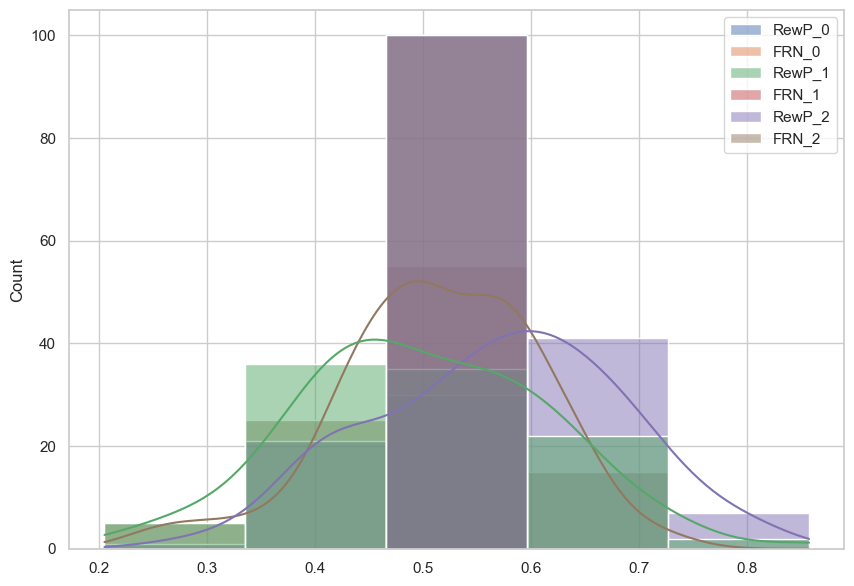

In [54]:
fig = sns.histplot(data=cv_results_df, bins=5, kde=True)

#### Test differences between the best models

Chose the best models

In [55]:
results_dep_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,RewP_Depression_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000
0,svc,RewP_Depression_svc,0.559444,0.530833,(SVC(C=1)),"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.318681,0.511667,0.603333,0.486667,0.520000,0.533889,0.530833,0.555051
0,lda,RewP_Depression_lda,0.571389,0.550556,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.165834,0.595000,0.666667,0.516667,0.573333,0.592778,0.550556,0.558776


In [56]:
results_dep_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,FRN_Depression_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.0,0.500000,0.500000,0.000000
0,svc,FRN_Depression_svc,0.500000,0.500000,"(SVC(C=0.0001, kernel='linear'))","{'svc__C': 0.0001, 'svc__kernel': 'linear'}",1.000000,0.399167,0.577500,0.523333,1.0,0.500000,0.500000,0.510204
0,lda,FRN_Depression_lda,0.525278,0.476389,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.734266,0.400000,0.576667,0.515000,0.8,0.497222,0.476389,0.486294


In [57]:
dep_rewp_model = results_dep_rewp_df.iloc[1].best_model
dep_rewp_model

Pipeline(steps=[('svc', SVC(C=1))])

In [58]:
dep_frn_model = results_dep_frn_df.iloc[0].best_model
dep_frn_model

Pipeline(steps=[('lg', LogisticRegression(penalty='l1', solver='liblinear'))])

- Balanced Accuracy

In [59]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)

In [60]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.015
p value: 0.494


- Roc AUC

In [61]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [62]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 1.173
p value: 0.122


- precision

In [63]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [64]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 2.647
p value: 0.005


- recall

In [65]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [66]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.186
p value: 0.426


- F1

In [67]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [68]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 1.181
p value: 0.120


Visualize difference between FRN and RewP models

In [69]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(dep_rewp_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
cv_scores_2 = cross_val_score(dep_frn_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')

In [70]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

In [71]:
cv_results_df

,RewP,FRN
0,0.383929,0.5
1,0.553571,0.5
2,0.553571,0.5
3,0.464286,0.5
4,0.553571,0.5
...,...,...
95,0.419643,0.5
96,0.428571,0.5
97,0.642857,0.5
98,0.428571,0.5


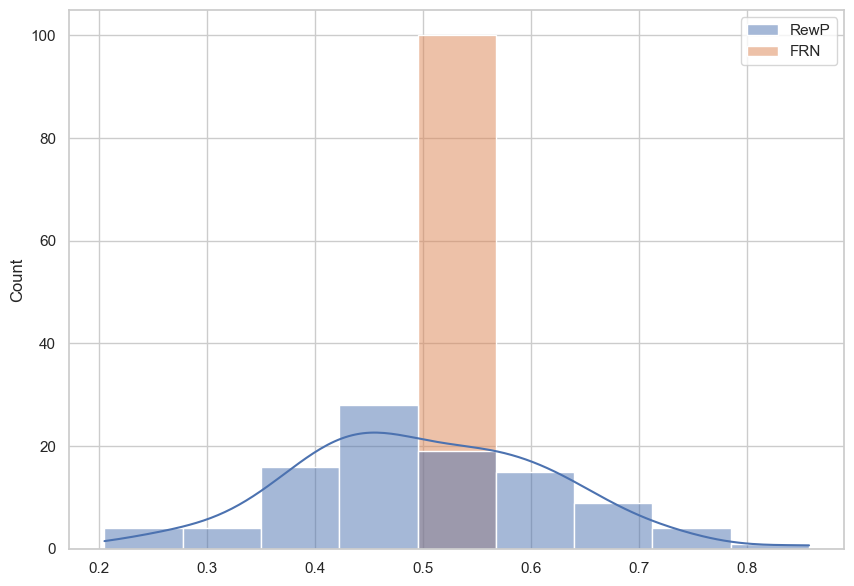

In [72]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

C:\Users\rafal\AppData\Local\Temp\ipykernel_26208\3509821564.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  fig = sns.kdeplot(data=cv_results_df, fill=True)


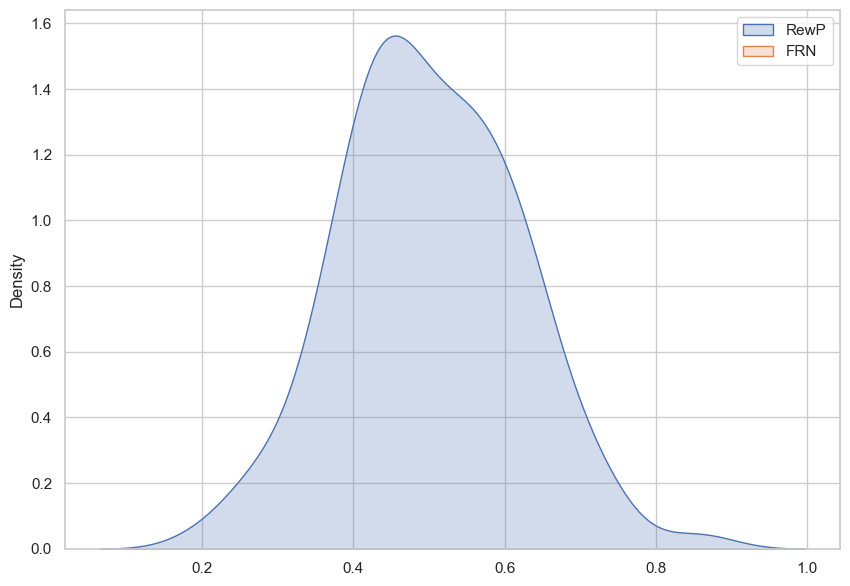

In [73]:
fig = sns.kdeplot(data=cv_results_df, fill=True)

In [74]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(dep_rewp_model, X_rewp, y, cv=cv, scoring='roc_auc')
cv_scores_2 = cross_val_score(dep_frn_model, X_frn, y, cv=cv,  scoring='roc_auc')

In [75]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

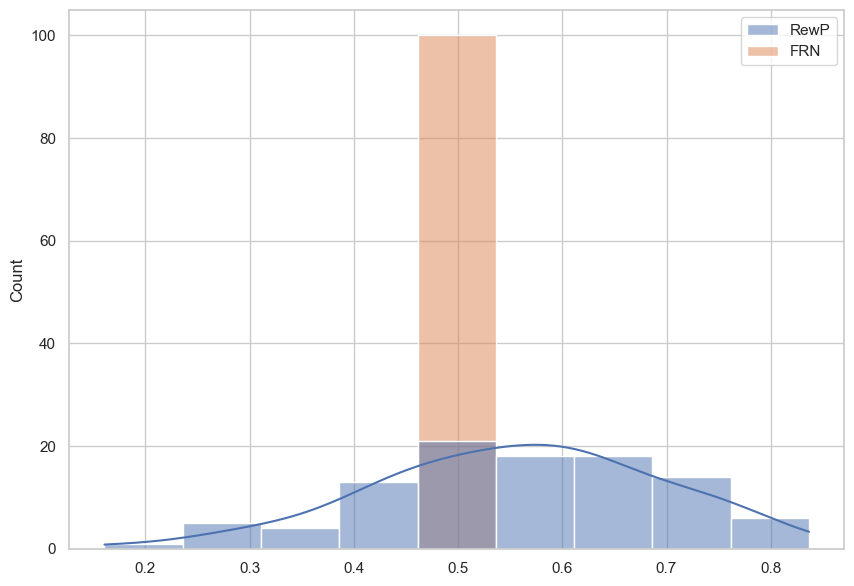

In [76]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

### Anxiety RewP vs FRN

In [77]:
y = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])

In [78]:
anx_rewp_data = []
ctrl_rewp_data = []
anx_rewp_data = get_rewps(anx, tmin, tmax)
ctrl_rewp_data = get_rewps(ctrl_anx, tmin, tmax)

In [79]:
X_rewp = pd.DataFrame(pd.concat([pd.DataFrame(anx_rewp_data), pd.DataFrame(ctrl_rewp_data)]))
#X_rewp = np.array(anx_rewp_data + ctrl_rewp_data)

In [80]:
anx_frn_data = []
ctrl_frn_data = []
anx_frn_data = get_fnrs(anx, tmin, tmax)
ctrl_frn_data = get_fnrs(ctrl_anx, tmin, tmax)

In [81]:
X_frn = pd.DataFrame(pd.concat([pd.DataFrame(anx_frn_data), pd.DataFrame(ctrl_frn_data)]))
#X_frn = np.array(anx_frn_data + ctrl_frn_data)

#### Plot differences between all Anxiety Models
To see which RewP and FRN models are the best

In [82]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_results_df = pd.DataFrame()

for i in range(0,len(results_anx_rewp_df)):
    cv_scores_rewp = cross_val_score(results_anx_rewp_df.iloc[i].best_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
    cv_scores_frn = cross_val_score(results_anx_frn_df.iloc[i].best_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')
    
    cv_results_df["RewP_" + str(i)] = cv_scores_rewp
    cv_results_df["FRN_" + str(i)] = cv_scores_frn

In [83]:
cv_results_df

,RewP_0,FRN_0,RewP_1,FRN_1,RewP_2,FRN_2
0,0.5,0.5,0.500000,0.500000,0.214286,0.428571
1,0.5,0.5,0.500000,0.464286,0.404762,0.321429
2,0.5,0.5,0.500000,0.785714,0.416667,0.547619
3,0.5,0.5,0.500000,0.392857,0.500000,0.321429
4,0.5,0.5,0.500000,0.500000,0.321429,0.547619
...,...,...,...,...,...,...
95,0.5,0.5,0.404762,0.666667,0.476190,0.309524
96,0.5,0.5,0.416667,0.452381,0.404762,0.547619
97,0.5,0.5,0.500000,0.452381,0.523810,0.476190
98,0.5,0.5,0.511905,0.547619,0.535714,0.607143


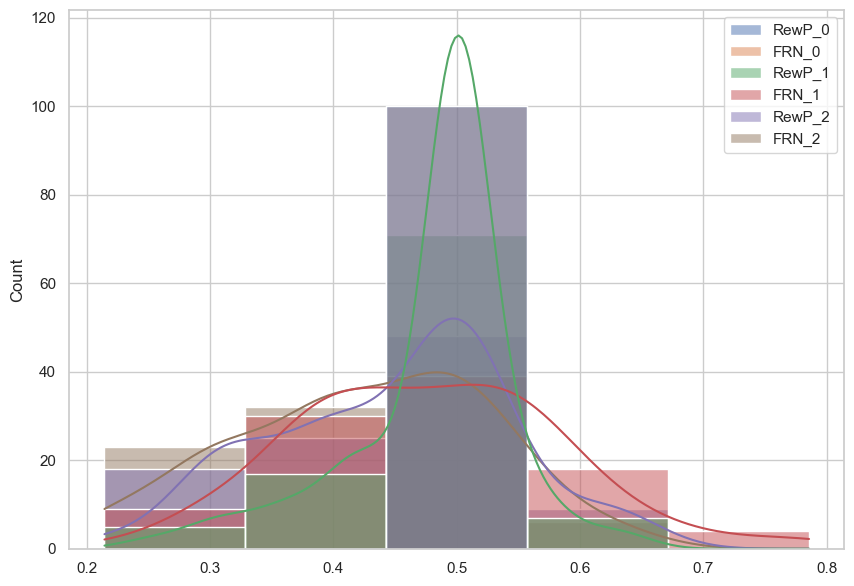

In [84]:
fig = sns.histplot(data=cv_results_df, bins=5, kde=True)

#### Test differences between the best models

Chose the best models

In [85]:
results_anx_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,RewP_Anxiety_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000
0,svc,RewP_Anxiety_svc,0.500000,0.485570,"(SVC(C=0.0001, kernel='linear'))","{'svc__C': 0.0001, 'svc__kernel': 'linear'}",0.795205,0.479339,0.415289,0.385281,0.031746,0.426636,0.485570,0.111111
0,lda,RewP_Anxiety_lda,0.501049,0.412338,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.974026,0.479339,0.413223,0.385281,0.324675,0.425948,0.412338,0.386364


In [86]:
results_anx_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,FRN_Anxiety_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000
0,svc,FRN_Anxiety_svc,0.563287,0.488456,(SVC(C=1)),"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.626374,0.549587,0.446281,0.378788,0.355700,0.458219,0.488456,0.486508
0,lda,FRN_Anxiety_lda,0.508392,0.495671,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.516484,0.446281,0.584711,0.441558,0.445887,0.490850,0.495671,0.498328


In [87]:
anx_rewp_model = results_anx_rewp_df.iloc[1].best_model
anx_rewp_model

Pipeline(steps=[('svc', SVC(C=0.0001, kernel='linear'))])

In [88]:
anx_frn_model = results_anx_frn_df.iloc[1].best_model
anx_frn_model

Pipeline(steps=[('svc', SVC(C=1))])

- Balanced Accuracy

In [89]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)

In [90]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.108
p value: 0.457


- Roc AUC

In [91]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [92]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.642
p value: 0.261


- precision

In [93]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [94]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -2.472
p value: 0.008


- recall

In [95]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [96]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -1.340
p value: 0.092


- F1

In [97]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [98]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -2.196
p value: 0.015


Visualize difference between FRN and RewP models

In [99]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')

In [100]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

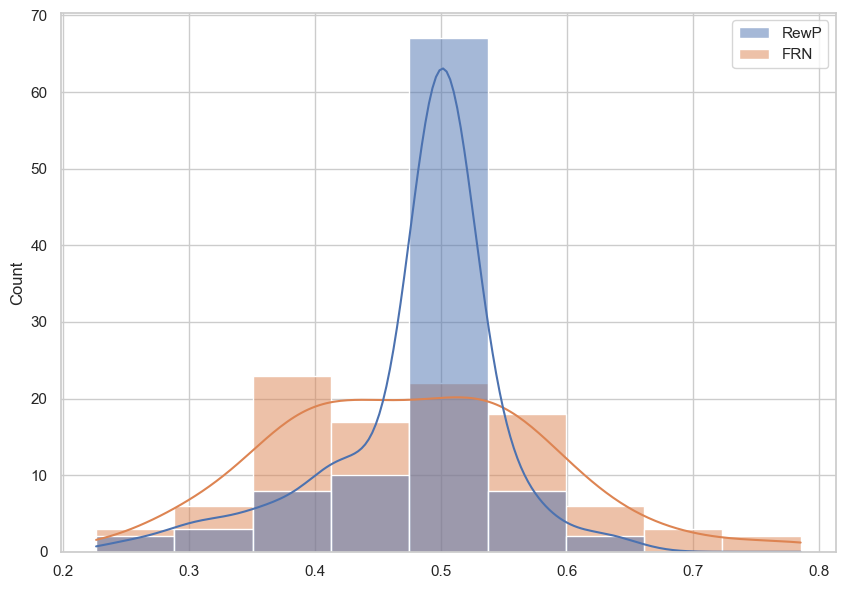

In [101]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

In [102]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='roc_auc')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='roc_auc')

In [103]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

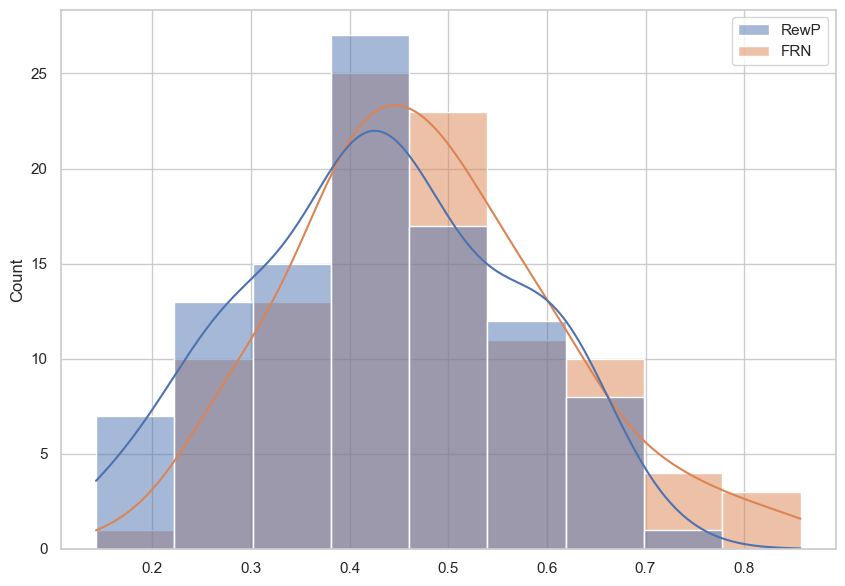

In [104]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

# Additional FRN

### Depression vs Control

In [383]:
def get_fnrs(epochs, frn_first_max, tmin, tmax):
  frns = []
  for i in range(len(epochs)):
    first_max = epochs.iloc[i]['epochs']['f_bad'].average().get_data(picks=picks, tmin=frn_first_max, tmax=tmax).max()
    second_max = epochs.iloc[i]['epochs']['f_bad'].average().get_data(picks=picks, tmin=tmin, tmax=tmax).max()
    diff = abs(first_max - second_max)
    frns.append(diff)
  return frns

In [384]:
dep_data = []
ctrl_data = []
dep_data = get_fnrs(dep, frn_first_max, tmin, tmax)
ctrl_data = get_fnrs(ctrl_dep, frn_first_max, tmin, tmax)

In [385]:
X = pd.DataFrame(pd.concat([pd.DataFrame(dep_data), pd.DataFrame(ctrl_data)]))
y = np.array(len(dep_data) * [1] +  len(ctrl_data) * [0])
len(y)

147

In [386]:
%%capture

results_dep_frn_df = pd.DataFrame()

vec = Vectorizer()
# cv = ShuffleSplit(3, test_size=0.3, random_state=random_state)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=random_state)

for (estimator, params) in estimators:
    print(f"Rating {estimator} \n")
    pipeline_name = "FRN_Depression_" + estimator[0]
    
      # create pipeline from base steps list and estimator
    pipe = Pipeline([estimator])

      # enter to grid search
    grid_result = evaluate_GS_model(
        pipe,
        X,
        y,
        params,
        pipeline_name=pipeline_name,
        predict_test = True,
        predict_train = True,
        cv=cv
    )
    print(grid_result)

    results_dep_frn_df = pd.concat([results_dep_frn_df, grid_result])

In [387]:
results_dep_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,FRN_Depression_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500,0.500000,0.00,0.500000,0.500000,0.000000
0,svc,FRN_Depression_svc,0.572778,0.565833,(SVC(C=1)),"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.051948,0.591667,0.555,0.631667,0.84,0.592778,0.565833,0.553349
0,lda,FRN_Depression_lda,0.566667,0.573611,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.035964,0.456667,0.560,0.658333,0.80,0.558333,0.573611,0.563715


In [388]:
results_dep_frn_df.to_pickle("data/depression__additional_frn_gng_06_06_23_2.pkl")

### Anxiety vs Control

In [389]:
anx_data = []
ctrl_data = []
anx_data = get_fnrs(anx,frn_first_max, tmin, tmax)
ctrl_data = get_fnrs(ctrl_anx, frn_first_max, tmin, tmax)

In [390]:
X = pd.DataFrame(pd.concat([pd.DataFrame(anx_data), pd.DataFrame(ctrl_data)]))
y = np.array(len(anx_data) * [1] +  len(ctrl_data) * [0])

In [391]:
print(f"ANX len: {len(anx_data)}\nCTR len: {len(ctrl_data)}")

ANX len: 65
CTR len: 66


In [392]:
%%capture

results_anx_frn_df = pd.DataFrame()

vec = Vectorizer()
# cv = ShuffleSplit(3, test_size=0.3, random_state=random_state)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=random_state)

for (estimator, params) in estimators:
    print(f"Rating {estimator} \n")
    pipeline_name = "FRN_Anxiety_" + estimator[0]
    
      # create pipeline from base steps list and estimator
    pipe = Pipeline([estimator])

      # enter to grid search
    grid_result = evaluate_GS_model(
        pipe,
        X,
        y,
        params,
        pipeline_name=pipeline_name,
        predict_test = True,
        predict_train = True,
        cv=cv
    )
    print(grid_result)

    results_anx_frn_df = pd.concat([results_anx_frn_df, grid_result])

In [393]:
results_anx_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,FRN_Anxiety_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000
0,svc,FRN_Anxiety_svc,0.586131,0.540765,(SVC(C=100)),"{'svc__C': 100, 'svc__kernel': 'rbf'}",0.257742,0.630165,0.520661,0.502165,0.323954,0.550997,0.540765,0.601307
0,lda,FRN_Anxiety_lda,0.451399,0.459957,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.780220,0.371901,0.489669,0.512987,0.435065,0.458186,0.459957,0.443476


In [394]:
results_anx_frn_df.to_pickle("data/anxiety_additional_frn_results_gng_06_06_2023_4.pkl")

In [395]:
results_dep_rewp_df = pd.read_pickle("data/depression_rewp_results_gng_06_06_23_1.pkl")
results_dep_frn_df = pd.read_pickle("data/depression__additional_frn_gng_06_06_23_2.pkl")
results_anx_rewp_df = pd.read_pickle("data/anxiety_rewp_results_gng_06_06_23_3.pkl")
results_anx_frn_df = pd.read_pickle("data/anxiety_additional_frn_results_gng_06_06_2023_4.pkl")

### Depression RewP vs FRN

In [396]:
y = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])

In [397]:
dep_rewp_data = []
ctrl_rewp_data = []
dep_rewp_data = get_rewps(dep, tmin, tmax)
ctrl_rewp_data = get_rewps(ctrl_dep, tmin, tmax)

In [398]:
X_rewp = pd.DataFrame(pd.concat([pd.DataFrame(dep_rewp_data), pd.DataFrame(ctrl_rewp_data)]))

In [399]:
dep_frn_data = []
ctrl_frn_data = []
dep_frn_data = get_fnrs(dep, frn_first_max, tmin, tmax)
ctrl_frn_data = get_fnrs(ctrl_dep, frn_first_max, tmin, tmax)

In [400]:
X_frn = pd.DataFrame(pd.concat([pd.DataFrame(dep_frn_data), pd.DataFrame(ctrl_frn_data)]))

In [401]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_results_df = pd.DataFrame()

for i in range(0,len(results_dep_rewp_df)):
    cv_scores_rewp = cross_val_score(results_dep_rewp_df.iloc[i].best_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
    cv_scores_frn = cross_val_score(results_dep_frn_df.iloc[i].best_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')
    
    cv_results_df["RewP_" + str(i)] = cv_scores_rewp
    cv_results_df["FRN_" + str(i)] = cv_scores_frn

In [402]:
cv_results_df

,RewP_0,FRN_0,RewP_1,FRN_1,RewP_2,FRN_2
0,0.5,0.5,0.383929,0.508929,0.383929,0.446429
1,0.5,0.5,0.553571,0.571429,0.803571,0.571429
2,0.5,0.5,0.553571,0.464286,0.616071,0.464286
3,0.5,0.5,0.464286,0.508929,0.464286,0.508929
4,0.5,0.5,0.553571,0.446429,0.607143,0.446429
...,...,...,...,...,...,...
95,0.5,0.5,0.419643,0.419643,0.473214,0.348214
96,0.5,0.5,0.428571,0.553571,0.553571,0.553571
97,0.5,0.5,0.642857,0.785714,0.714286,0.785714
98,0.5,0.5,0.428571,0.571429,0.428571,0.571429


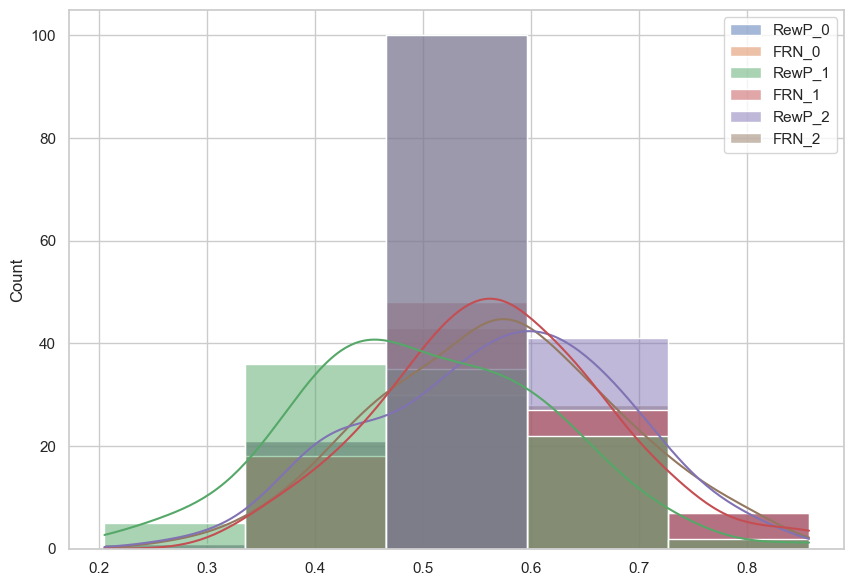

In [403]:
fig = sns.histplot(data=cv_results_df, bins=5, kde=True)

In [404]:
results_dep_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,RewP_Depression_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000
0,svc,RewP_Depression_svc,0.559444,0.530833,(SVC(C=1)),"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.318681,0.511667,0.603333,0.486667,0.520000,0.533889,0.530833,0.555051
0,lda,RewP_Depression_lda,0.571389,0.550556,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.165834,0.595000,0.666667,0.516667,0.573333,0.592778,0.550556,0.558776


In [405]:
results_dep_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,FRN_Depression_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500,0.500000,0.00,0.500000,0.500000,0.000000
0,svc,FRN_Depression_svc,0.572778,0.565833,(SVC(C=1)),"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.051948,0.591667,0.555,0.631667,0.84,0.592778,0.565833,0.553349
0,lda,FRN_Depression_lda,0.566667,0.573611,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.035964,0.456667,0.560,0.658333,0.80,0.558333,0.573611,0.563715


In [406]:
dep_rewp_model = results_dep_rewp_df.iloc[1].best_model
dep_rewp_model

Pipeline(steps=[('svc', SVC(C=1))])

In [407]:
dep_frn_model = results_dep_frn_df.iloc[0].best_model
dep_frn_model

Pipeline(steps=[('lg', LogisticRegression(penalty='l1', solver='liblinear'))])

In [408]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)


In [409]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.015
p value: 0.494


In [410]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [411]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 1.173
p value: 0.122


In [412]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [413]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 2.647
p value: 0.005


In [414]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [415]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.186
p value: 0.426


In [416]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [417]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 1.181
p value: 0.120


In [418]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(dep_rewp_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
cv_scores_2 = cross_val_score(dep_frn_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')

In [419]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

In [420]:
cv_results_df

,RewP,FRN
0,0.383929,0.5
1,0.553571,0.5
2,0.553571,0.5
3,0.464286,0.5
4,0.553571,0.5
...,...,...
95,0.419643,0.5
96,0.428571,0.5
97,0.642857,0.5
98,0.428571,0.5


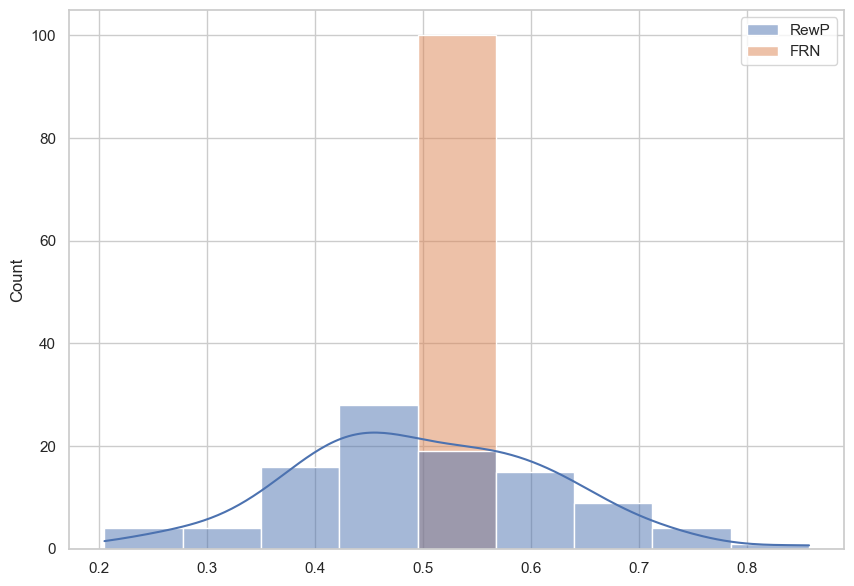

In [421]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

C:\Users\rafal\AppData\Local\Temp\ipykernel_26208\3509821564.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  fig = sns.kdeplot(data=cv_results_df, fill=True)


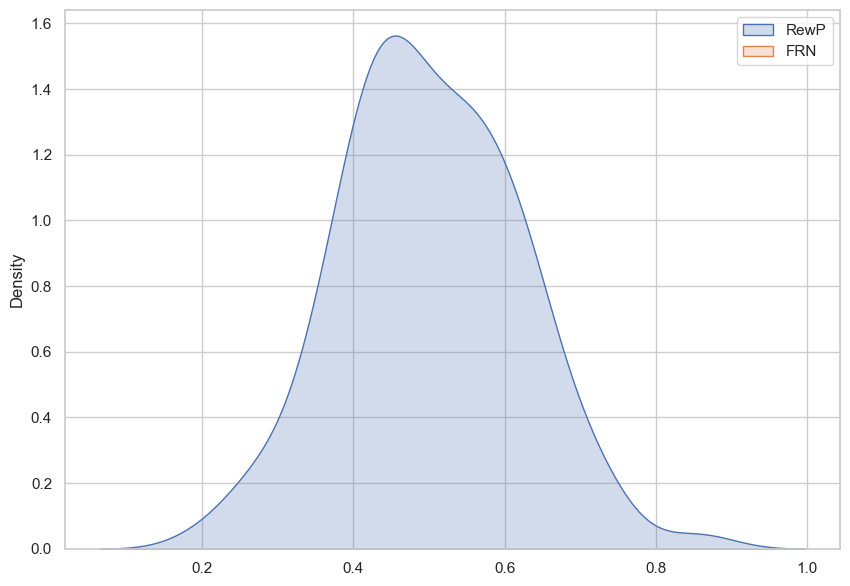

In [422]:
fig = sns.kdeplot(data=cv_results_df, fill=True)

In [423]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(dep_rewp_model, X_rewp, y, cv=cv, scoring='roc_auc')
cv_scores_2 = cross_val_score(dep_frn_model, X_frn, y, cv=cv,  scoring='roc_auc')

In [424]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

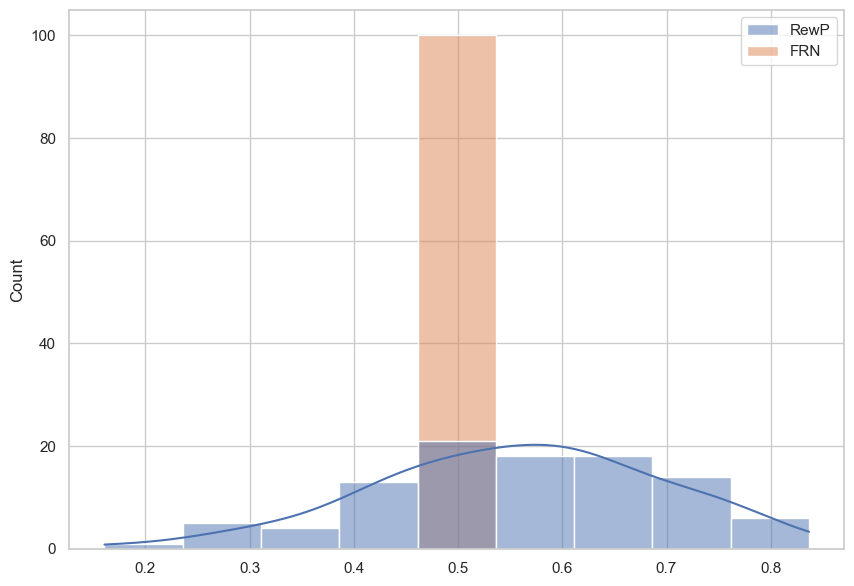

In [425]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

### Anxiety RewP vs FRN

In [426]:
y = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])

In [427]:
anx_rewp_data = []
ctrl_rewp_data = []
anx_rewp_data = get_rewps(anx, tmin, tmax)
ctrl_rewp_data = get_rewps(ctrl_anx, tmin, tmax)

In [428]:
X_rewp = pd.DataFrame(pd.concat([pd.DataFrame(anx_rewp_data), pd.DataFrame(ctrl_rewp_data)]))
#X_rewp = np.array(anx_rewp_data + ctrl_rewp_data)

In [429]:
anx_frn_data = []
ctrl_frn_data = []
anx_frn_data = get_fnrs(anx, frn_first_max, tmin, tmax)
ctrl_frn_data = get_fnrs(ctrl_anx, frn_first_max, tmin, tmax)

In [430]:
X_frn = pd.DataFrame(pd.concat([pd.DataFrame(anx_frn_data), pd.DataFrame(ctrl_frn_data)]))
#X_frn = np.array(anx_frn_data + ctrl_frn_data)

In [431]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_results_df = pd.DataFrame()

for i in range(0,len(results_anx_rewp_df)):
    cv_scores_rewp = cross_val_score(results_anx_rewp_df.iloc[i].best_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
    cv_scores_frn = cross_val_score(results_anx_frn_df.iloc[i].best_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')
    
    cv_results_df["RewP_" + str(i)] = cv_scores_rewp
    cv_results_df["FRN_" + str(i)] = cv_scores_frn

In [432]:
cv_results_df

,RewP_0,FRN_0,RewP_1,FRN_1,RewP_2,FRN_2
0,0.5,0.5,0.500000,0.642857,0.214286,0.357143
1,0.5,0.5,0.500000,0.642857,0.404762,0.476190
2,0.5,0.5,0.500000,0.571429,0.416667,0.357143
3,0.5,0.5,0.500000,0.630952,0.500000,0.369048
4,0.5,0.5,0.500000,0.476190,0.321429,0.500000
...,...,...,...,...,...,...
95,0.5,0.5,0.404762,0.607143,0.476190,0.476190
96,0.5,0.5,0.416667,0.535714,0.404762,0.309524
97,0.5,0.5,0.500000,0.523810,0.523810,0.369048
98,0.5,0.5,0.511905,0.678571,0.535714,0.321429


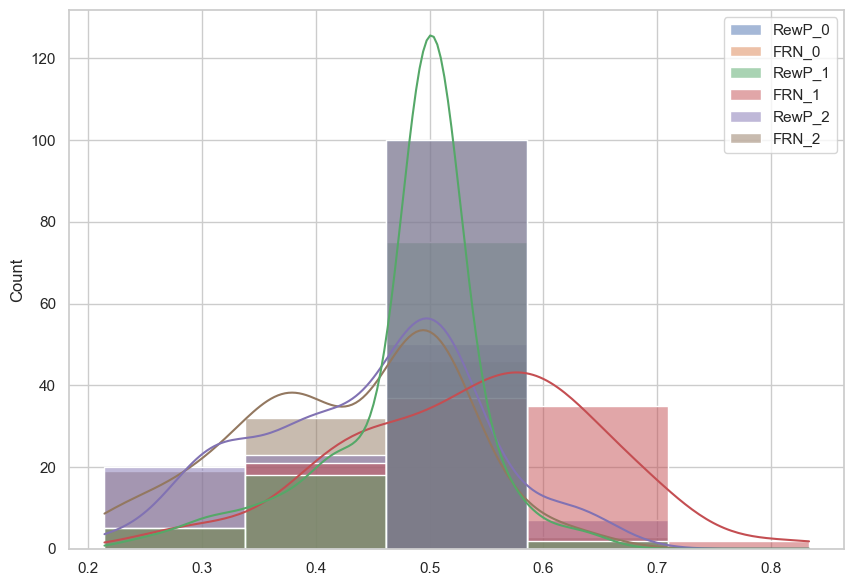

In [433]:
fig = sns.histplot(data=cv_results_df, bins=5, kde=True)

In [434]:
results_anx_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,RewP_Anxiety_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000
0,svc,RewP_Anxiety_svc,0.500000,0.485570,"(SVC(C=0.0001, kernel='linear'))","{'svc__C': 0.0001, 'svc__kernel': 'linear'}",0.795205,0.479339,0.415289,0.385281,0.031746,0.426636,0.485570,0.111111
0,lda,RewP_Anxiety_lda,0.501049,0.412338,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.974026,0.479339,0.413223,0.385281,0.324675,0.425948,0.412338,0.386364


In [435]:
results_anx_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_recall,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_precision
0,lg,FRN_Anxiety_lg,0.500000,0.500000,"(LogisticRegression(penalty='l1', solver='libl...",{},1.000000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000
0,svc,FRN_Anxiety_svc,0.586131,0.540765,(SVC(C=100)),"{'svc__C': 100, 'svc__kernel': 'rbf'}",0.257742,0.630165,0.520661,0.502165,0.323954,0.550997,0.540765,0.601307
0,lda,FRN_Anxiety_lda,0.451399,0.459957,"(LinearDiscriminantAnalysis(shrinkage='auto', ...","{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}",0.780220,0.371901,0.489669,0.512987,0.435065,0.458186,0.459957,0.443476


In [436]:
anx_rewp_model = results_anx_rewp_df.iloc[1].best_model
anx_rewp_model

Pipeline(steps=[('svc', SVC(C=0.0001, kernel='linear'))])

In [437]:
anx_frn_model = results_anx_frn_df.iloc[1].best_model
anx_frn_model

Pipeline(steps=[('svc', SVC(C=100))])

In [438]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)


In [439]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -1.154
p value: 0.126


In [440]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [441]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -1.329
p value: 0.093


In [442]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [443]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -2.857
p value: 0.003


In [444]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [445]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -1.314
p value: 0.096


In [446]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [447]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -2.313
p value: 0.011


In [448]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='balanced_accuracy')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='balanced_accuracy')

In [449]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

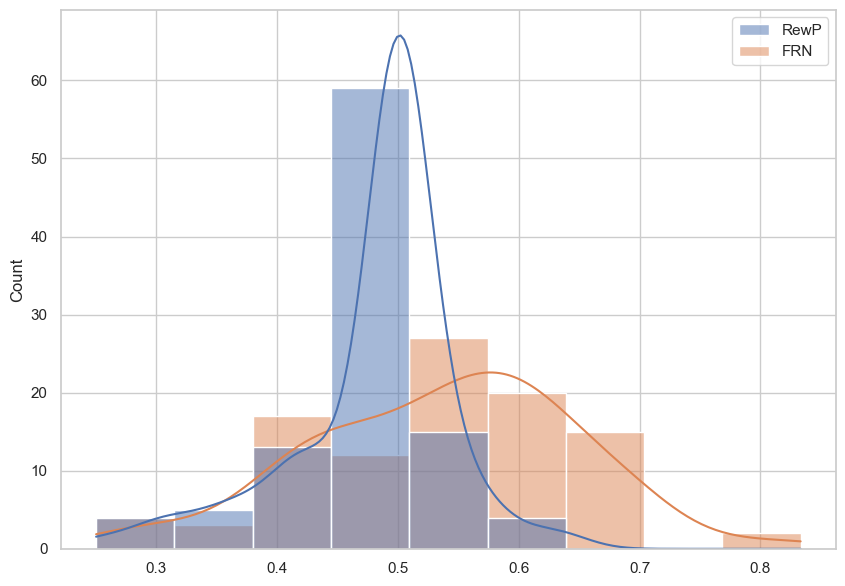

In [450]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

In [451]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='roc_auc')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='roc_auc')

In [452]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

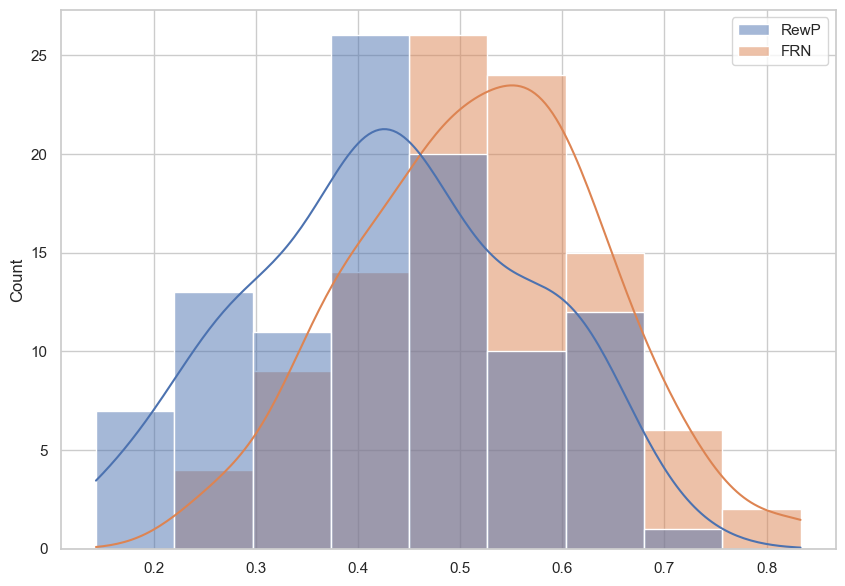

In [453]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)